In [1]:
'''
This notebook will output a dataset .npy of Lagrangian particle flow map
Total particle number : Nx x Ny
Finite Time interval : t0 --> t0 + T (trajectory data during this T will not be saved)
Output variable : 2D numpy array of tuples;
                  Each tuple (x0, y0, x1, y1) stores initial and final positions of a Lagrangian particle,
                  i.e. r(t0) = (x0, y0) and r(t0+T) = (x1, y1)
''' 


import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi

from scipy import integrate
import scipy as sp

In [2]:
### create flow domain 
# there are same number of Lagrangian and Eulerian grid points (Nx, Ny)
Lx, Ly = (2, 1)
Nx, Ny = (201, 101)
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
X, Y = np.meshgrid(x,y)
dx = Lx/(Nx-1)
dy = dx

t0 = 0
tf = 7.5

In [3]:
### compute a double gyro flow field

# flow parameters
A = 0.1
eps = 0.25
omega = 0.6*pi

# flow streamline
a = lambda t: eps * np.sin(omega * t)
b = lambda t: 1 - 2 * a(t)
fxt = lambda x, t: a(t) * (x**2) + b(t) * x
psi = lambda x,y,t: A * np.sin(np.pi*fxt(x,t)) * np.sin(np.pi*y)

# flow velocity field (need to sort out the signs!!)
U = lambda x,y,t: -A*np.pi * np.sin(np.pi*fxt(x,t)) * np.cos(np.pi*y)
V = lambda x,y,t: A*np.pi * np.cos(np.pi*fxt(x,t)) * np.sin(np.pi*y) * (2*a(t)*x + b(t))

# # visualise flow field at t0
# t0 = 0
# fig, ax = plt.subplots(layout='constrained')
# CS = ax.contourf(X, Y, V(X,Y,t0), 50)
# ax.set_aspect('equal')
# fig.colorbar(CS)

In [4]:
#### compute particle trajectories

# Solve the IVP RK4 -- for FLUID particles
def solve_ivp_passive(r0, t0=t0, tf=tf):

      """
      argument r0 should be a LIST : [x0, y0]
      """

      # define the IVP to solve -- for FLUID particles
      t_span = np.linspace(t0,tf,600)

      def passive_tracer_traj(t, r):
            X, Y = r
            a = eps * sin(omega * t)
            b = 1 - 2 * eps * sin(omega * t)
            fxt = a*(X**2) + b*X
            fx = -A * pi * sin(pi*fxt) * cos(pi*Y)
            fy = A * pi * cos(np.pi*fxt) * np.sin(np.pi*Y) * (2*a*X + b)
            return [-fx, -fy]

      passive_sol = sp.integrate.solve_ivp(passive_tracer_traj, [t0,tf], r0, t_eval=t_span, vectorized=True)
      xt, yt = passive_sol.y
      return xt, yt


In [5]:
### compute the particle flow map in the whole domain

# create a flattened array of grid points, first index is x
grid_coords = np.column_stack((X.ravel(), Y.ravel()))
final_coords = np.empty_like(grid_coords, dtype=object)

# # loop through all lagrangian grid points to find final positions
# for i, point in enumerate(grid_coords):
#     r0 = [grid_coords[i, 0], grid_coords[i, 1]]
#     rt = solve_ivp_passive(r0, t0, tf)
#     final_coords[i,:] = [rt[k][-1] for k in [0,1]]

## using multiprocessing
'''
output [res], a list with len = Nx*Ny, 
each list element is an array of t_span for one particle
'''
from multiprocessing import Pool

n_proc = 4
with Pool(n_proc) as pool:
    args = list( grid_coords )
    res = pool.map( solve_ivp_passive, args )

final_coords = np.array([(point[0][-1], point[1][-1]) for point in res], dtype=float)




# flow map, each row has 4 entries [x0, y0, xf, yf]
flow_map = np.column_stack((grid_coords, final_coords))
# np.save('passive_flow_map_negative.npy', flow_map)



In [6]:
# this is a 3D array and the first two indicies are the particle "Name" (defined by its initial position)
flow_map_arr = np.array([tuple(row) for row in flow_map]).reshape((Ny, Nx, 4))
X0 = flow_map_arr[:,:,0]
Y0 = flow_map_arr[:,:,1]
Xf = flow_map_arr[:,:,2]
Yf = flow_map_arr[:,:,3]

In [7]:
def compute_ftle(xi, yj, t0, tf):

    D = np.zeros((2,2))   # 2D deformation gradient matrix
    D[0,0] = (Xf[yj, xi+1] - Xf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[0,1] = (Xf[yj+1, xi] - Xf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])
    D[1,0] = (Yf[yj, xi+1] - Yf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[1,1] = (Yf[yj+1, xi] - Yf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])

    # CGDtensor = D.T @ D # symmetric square real matrix must have orthogonal eigenvectors,  the SV's are the absolute values of the eigenvalues
    # _, SV, _ = np.linalg.svd(CGDtensor, hermitian=True)

    _, SV, _ = np.linalg.svd(D)

    if SV[0] < 1:
        SV = np.ones_like(SV)
    else:
        SV[1] = 1/SV[0]

    ftle = np.log(SV[0]) / np.abs(tf-t0)
    
    return ftle

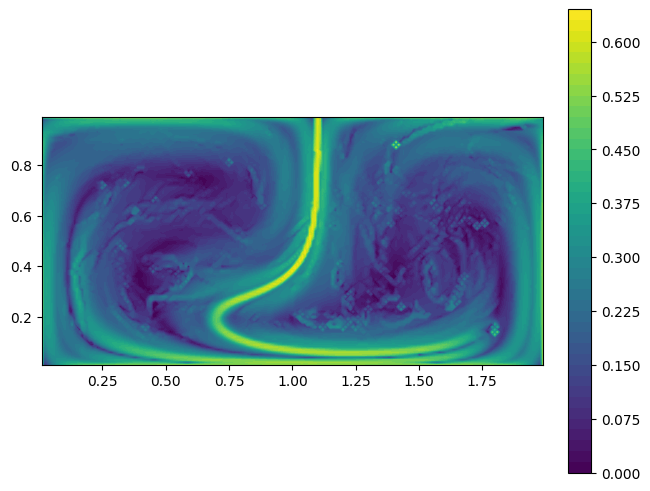

In [8]:
FTLE_field = np.empty((Ny-2, Nx-2))

for xi in range(Nx-2) :
    for yj in range(Ny-2) :
        FTLE_field[yj, xi] = compute_ftle((xi+1), (yj+1), t0=0, tf=7.5)

fig, ax = plt.subplots(layout='constrained')
CS = ax.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, 50)
ax.set_aspect('equal')
cbar = fig.colorbar(CS)

In [ ]:
type(res)